## **PNEUMONIA IDENTIFICATION FROM CHEST X-RAY IMAGES**


Anna Camprubi Buxeda and Gema Novo Rego

## **1. Introduction**


### **1.1 Pneumonia**



Pneumonia is a serious respiratory disease that leads to inflammation in the alveoli, the tiny air sacs of the lungs. These sacs may fill with fluid or pus, causing symptoms like coughing, fever, chills, and difficulty breathing. The severity of pneumonia varies, from mild symptoms to life-threatening complications requiring hospitalization. The impact of pneumonia is particularly severe in vulnerable populations, such as children under five and elderly individuals. According to the World Health Organization (2021), pneumonia was responsible for 740,180 deaths in children under five in 2019, highlighting its global health burden.


### **1.2 Symptoms**

Common symptoms of pneumonia include:

- Persistent cough producing green, yellow, or blood-tinged mucus.

- Fever, sweating, and chills.

- Difficulty breathing and rapid, shallow breathing.

- Sharp chest pain, especially when coughing or deep breathing.

- Fatigue, loss of appetite, and nausea.

- Confusion, particularly in older adults

### **1.3 Diagnosis**

Diagnosing pneumonia can be challenging due to symptom overlap with other respiratory infections. Doctors use various tests to confirm pneumonia and identify its cause, including:

- Blood tests to detect infection and identify causative pathogens.

- Pulse oximetry to measure oxygen levels in the blood.

- Sputum tests to analyze mucus samples for bacterial infections.

- Chest X-rays to determine inflammation severity and location.

- CT scans for detailed imaging in high-risk cases.

- Bronchoscopy for direct examination of the airways in severe cases.


### **1.4. AI in Radiology**

Artificial intelligence (AI) has revolutionized medical image analysis, particularly in radiology. Deep learning techniques, such as convolutional neural networks (CNNs), enable automated detection of pneumonia in chest X-rays with high accuracy. Traditionally, radiologists manually examined X-ray images to diagnose lung conditions. AI enhances this process by identifying complex patterns and providing quantitative assessments of radiographic features, improving diagnostic efficiency and accuracy.



## **2. Project overview**


The aim of this project is to develop a deep learning model capable of classifying chest X-ray images into two categories: pneumonia-positive or normal. The model will be implemented using PySpark with a high-level interface, incorporating Analytics Zoo to optimize performance on large-scale datasets.



### **2.1. The dataset**

The dataset consists of 5,863 chest X-ray images categorized into pneumonia-positive and normal cases. It is divided into three subsets:

- Training set for model learning.

- Validation set for hyperparameter tuning.

- Test set for final model evaluation.

These images were collected from pediatric patients (ages 1-5) at Guangzhou Women and Children's Medical Center, ensuring high-quality diagnostic imaging. A team of radiologists validated the dataset to minimize errors and ensure reliability.

By leveraging AI and big data frameworks like PySpark, this project aims to enhance pneumonia diagnosis, potentially improving clinical outcomes and aiding healthcare professionals in early detection.

## **3. Importing the libraries**

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


## **4. Loading the data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
#kaggle.jason API key

!cp "/content/drive/MyDrive/kaggle/kaggle.json" "/content"
!chmod 600 /content/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:16<00:00, 255MB/s]
100% 2.29G/2.29G [00:16<00:00, 151MB/s]


In [ ]:
ls /content/dataset/chest_xray

In [5]:
# Initialize Spark session for distributed data processing
appname = "Pneumonia detection X-ray"
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()
spark

## **5. Creating the dataframes**

***For the train data***

In [56]:
# Defining the paths to the datasets
train_normal = "/content/dataset/chest_xray/train/NORMAL"
train_pneumonia = "/content/dataset/chest_xray/train/PNEUMONIA"

#Getting the list of image file paths with the labels
train_normal_images = [(os.path.join(train_normal, f), 0) for f in os.listdir(train_normal) if f.endswith(".jpeg")]
train_pneumonia_images = [(os.path.join(train_pneumonia, f), 1) for f in os.listdir(train_pneumonia) if f.endswith(".jpeg")]

#Combining both classes
train_data = train_normal_images + train_pneumonia_images

#Defining the schema
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", IntegerType(), True)
])

# Now we create the PySpark DataFrame
train_dataframe = spark.createDataFrame(train_data, schema=schema)

#And show the DataFrame
train_dataframe.show(5, truncate=False)

+------------------------------------------------------------------+-----+
|image_path                                                        |label|
+------------------------------------------------------------------+-----+
|/content/dataset/chest_xray/train/NORMAL/IM-0480-0001.jpeg        |0    |
|/content/dataset/chest_xray/train/NORMAL/IM-0152-0001.jpeg        |0    |
|/content/dataset/chest_xray/train/NORMAL/IM-0527-0001.jpeg        |0    |
|/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-1278-0001.jpeg|0    |
|/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg|0    |
+------------------------------------------------------------------+-----+
only showing top 5 rows



In [26]:
# Check the balance of the dataset
train_dataframe.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 3875|
|    0| 1341|
+-----+-----+



***For the test data***

In [57]:
# Defining the paths to the datasets
test_normal = "/content/dataset/chest_xray/test/NORMAL"
test_pneumonia = "/content/dataset/chest_xray/test/PNEUMONIA"

#Getting the list of image file paths with the labels
test_normal_images = [(os.path.join(test_normal, f), 0) for f in os.listdir(test_normal) if f.endswith(".jpeg")]
test_pneumonia_images = [(os.path.join(test_pneumonia, f), 1) for f in os.listdir(test_pneumonia) if f.endswith(".jpeg")]

#Combining both classes
test_data = test_normal_images + test_pneumonia_images

#Defining the schema
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", IntegerType(), True)
])

# Now we create the PySpark DataFrame
test_dataframe = spark.createDataFrame(test_data, schema=schema)

#And show the DataFrame
test_dataframe.show(5, truncate=False)

+-----------------------------------------------------------------+-----+
|image_path                                                       |label|
+-----------------------------------------------------------------+-----+
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0098-0001.jpeg|0    |
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg|0    |
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0278-0001.jpeg|0    |
|/content/dataset/chest_xray/test/NORMAL/IM-0103-0001.jpeg        |0    |
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0378-0001.jpeg|0    |
+-----------------------------------------------------------------+-----+
only showing top 5 rows



In [28]:
# Check the balance of the dataset

test_dataframe.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  390|
|    0|  234|
+-----+-----+



***For the val data***

In [58]:
# Defining the paths to the datasets
val_normal = "/content/dataset/chest_xray/val/NORMAL"
val_pneumonia = "/content/dataset/chest_xray/val/PNEUMONIA"

#Getting the list of image file paths with the labels
val_normal_images = [(os.path.join(val_normal, f), 0) for f in os.listdir(val_normal) if f.endswith(".jpeg")]
val_pneumonia_images = [(os.path.join(val_pneumonia, f), 1) for f in os.listdir(val_pneumonia) if f.endswith(".jpeg")]

#Combining both classes
val_data = val_normal_images + val_pneumonia_images

#Defining the schema
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", IntegerType(), True)
])

# Now we create the PySpark DataFrame
val_dataframe = spark.createDataFrame(val_data, schema=schema)

#And show the DataFrame
val_dataframe.show(5, truncate=False)

+----------------------------------------------------------------+-----+
|image_path                                                      |label|
+----------------------------------------------------------------+-----+
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg|0    |
+----------------------------------------------------------------+-----+
only showing top 5 rows



In [30]:
# Check the balance of the dataset

val_dataframe.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|    8|
|    1|    8|
+-----+-----+



## **6. Visualizing the data**

***Check the distribution of the data***

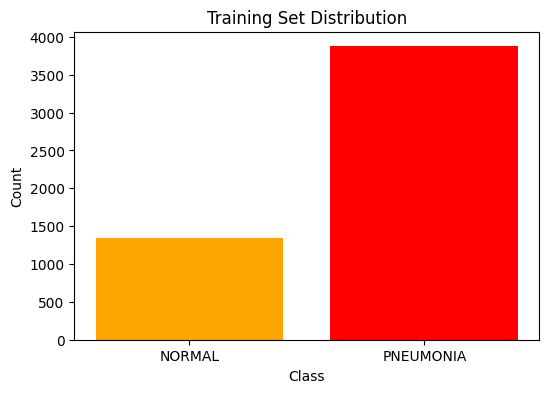

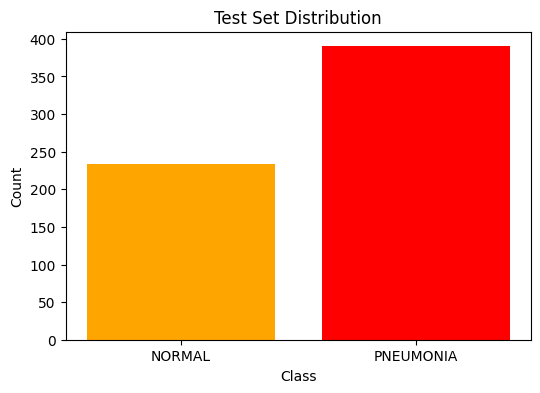

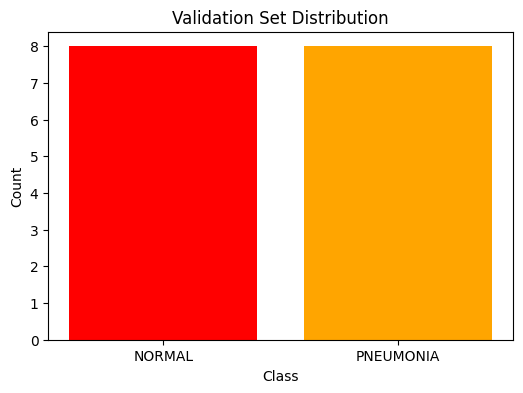

In [31]:

def plot_distribution(data, title):
    """
    Function to plot the class distribution in the dataset.

    Parameters:
    - data: Spark DataFrame containing a column named 'label'.
    - title: Title of the plot.

    The function groups the data by the 'label' column, counts the occurrences of each class,
    converts it to a Pandas DataFrame, and creates a bar chart to visualize the class distribution.
    """

    # Count the number of occurrences for each label (0 = NORMAL, 1 = PNEUMONIA)
    label_counts = data.groupBy("label").count().toPandas()

    # Set figure size for the plot
    plt.figure(figsize=(6, 4))

    # Create a bar plot with labels 0 (NORMAL) and 1 (PNEUMONIA)
    plt.bar(label_counts["label"], label_counts["count"], color=["red", "orange"])

    # Define x-axis tick labels
    plt.xticks([0, 1], ["NORMAL", "PNEUMONIA"])

    # Set labels for the x and y axes
    plt.xlabel("Class")
    plt.ylabel("Count")

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

# Plot the class distribution for the training dataset
plot_distribution(train_dataframe, "Training Set Distribution")
print("")  # Print an empty string to separate outputs

# Plot the class distribution for the test dataset
plot_distribution(test_dataframe, "Test Set Distribution")
print("")

# Plot the class distribution for the validation dataset
plot_distribution(val_dataframe, "Validation Set Distribution")


***Check the images***

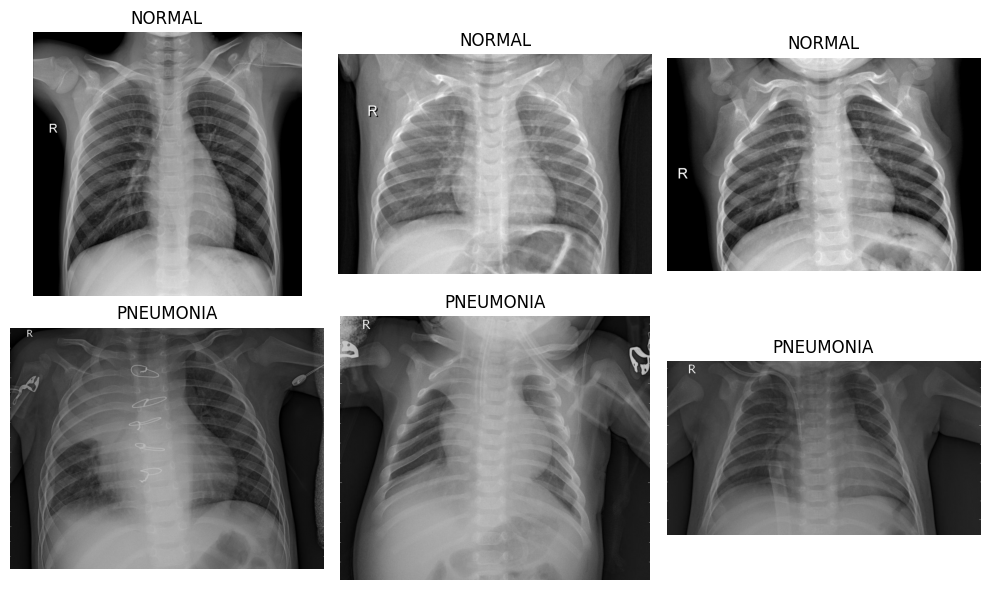

In [32]:

def show_images(data, samples=3):
    fig, axes = plt.subplots(2, samples, figsize=(10, 6))  # Create a grid of subplots
    labels = {0: "NORMAL", 1: "PNEUMONIA"}  # Label mapping

    for label in [0, 1]:  # Loop through each class
        images = (data.filter(col("label") == label)
                     .select("image_path")
                     .limit(samples)
                     .toPandas()["image_path"]
                     .tolist())  # Get file paths for selected images

        for i, img_path in enumerate(images):  # Loop through selected images
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            axes[label, i].imshow(img, cmap="gray")  # Display image
            axes[label, i].axis("off")  # Remove axis labels
            axes[label, i].set_title(labels[label])  # Set title as class label

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Show the images

# Show sample images from the training dataset
show_images(train_dataframe)


Now we are going to convert raw chest X-ray images into numerical feature vectors using TensorFlow’s ResNet50 model. Since PySpark does not support Convolutional Neural Networks (CNNs) or direct image processing, TensorFlow is used to extract deep-learning-based features from the images, which are then stored in a PySpark DataFrame for further processing.

## **7. Feature extraction from images**

In [59]:

# Load Pretrained ResNet50 Model
model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Define a function to load and process images
def extract_features(image_path):
    try:
        print(f" Processing: {image_path}")

        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            return None

        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        # Extract features using ResNet50
        features = model.predict(img_array)

        print(f"Features extracted successfully for {image_path}")

        return features.flatten().tolist()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Convert feature extraction function into a PySpark UDF
extract_features_udf = udf(extract_features, ArrayType(FloatType()))

# Apply the feature extraction function to the dataset
train_dataframe = train_dataframe.withColumn("features", extract_features_udf(col("image_path")))
test_dataframe = test_dataframe.withColumn("features", extract_features_udf(col("image_path")))
val_dataframe = val_dataframe.withColumn("features", extract_features_udf(col("image_path")))

# Drop unnecessary columns (image_paths)
train_dataframe = train_dataframe.select("features", "label")
test_dataframe = test_dataframe.select("features", "label")
val_dataframe = val_dataframe.select("features", "label")

# Show results
train_dataframe.show(5, truncate=True)
test_dataframe.show(5, truncate=True)
val_dataframe.show(5, truncate=True)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.6344807, 2.929...|    0|
|[3.1436348, 4.474...|    0|
|[2.9793222, 0.212...|    0|
|[2.164638, 2.6013...|    0|
|[2.0147278, 2.800...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.7424793, 0.065...|    0|
|[2.3086174, 1.888...|    0|
|[3.5584226, 0.579...|    0|
|[2.4490676, 0.633...|    0|
|[1.2507448, 0.521...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0000358, 0.812...|    0|
|[2.5940855, 0.950...|    0|
|[3.5293016, 0.468...|    0|
|[1.9594879, 1.655...|    0|
|[1.6328312, 0.833...|    0|
+--------------------+-----+
only showing top 5 rows



***Vector assembly***

In [60]:
# Convert extracted feature arrays into Spark ML Vectors for compatibility with Machine learning models
array_to_vector_udf = udf(lambda x: Vectors.dense(x) if x is not None else None, VectorUDT())

# Apply the transformation to convert feature lists into vector format
train_dataframe = train_dataframe.withColumn("features", array_to_vector_udf("features"))
test_dataframe = test_dataframe.withColumn("features", array_to_vector_udf("features"))
val_dataframe = val_dataframe.withColumn("features", array_to_vector_udf("features"))

# Assemble feature vectors into a new column to prepare the dataset for Spark ML algorithms
vector_assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")

# Transform the DataFrames to include only the assembled feature vectors and labels
train_dataframe = vector_assembler.transform(train_dataframe).select("features_vector", "label")
test_dataframe = vector_assembler.transform(test_dataframe).select("features_vector", "label")
val_dataframe = vector_assembler.transform(val_dataframe).select("features_vector", "label")

# Display the transformed DataFrames to verify the feature vector conversion
train_dataframe.show(5, truncate=False)
test_dataframe.show(5, truncate=False)
val_dataframe.show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **8. Evaluation of the model**

In [62]:
# Initialize a Logistic Regression model
lr = LogisticRegression(featuresCol="features_vector", labelCol="label")

# Initialize a Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="label", numTrees=100)

# Determine the input dimension dynamically based on the feature vector size
input_dim = train_dataframe.select("features_vector").first()[0].size

# Define a Multi-Layer Perceptron (MLP) model with two hidden layers
mlp = MultilayerPerceptronClassifier(featuresCol="features_vector", labelCol="label",
                                     layers=[input_dim, 64, 32, 10], maxIter=100)

# Define an evaluator to measure model performance based on accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


### **Logistic Regression**

In [ ]:
# Optimize Hyperparameter Grid
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .build()

# Enable Parallel Processing & Reduce Folds
crossvalidation_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid,
                                    evaluator=evaluator, numFolds=2, parallelism=2)

# Cache training data to speed up computations
train_dataframe.cache()

# Train using a smaller sample for debugging (optional)
train_sample = train_dataframe.sample(fraction=0.2)

# Train the cross-validation model
cv_lr_model = crossvalidation_lr.fit(train_sample)

# Retrieve the best model
cv_best_lr_model = cv_lr_model.bestModel

# Predict on validation set
cv_lr_predictions = cv_best_lr_model.transform(val_dataframe)

# Compute accuracy
cv_lr_accuracy = evaluator.evaluate(cv_lr_predictions)
print(f"Best Logistic Regression model validation accuracy: {cv_lr_accuracy * 100:.2f}%")


### **Random Forest**

In [ ]:
# Define a hyperparameter grid for Random Forest to optimize depth and tree count
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Perform cross-validation to find the best Random Forest model
crossvalidation_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=evaluator, numFolds=3)

# Train the cross-validation model for Random Forest
cv_rf_model = crossvalidation_rf.fit(train_dataframe)

# Retrieve the best model from cross-validation
cv_best_rf_model = cv_rf_model.bestModel

# Generate predictions using the best Random Forest model
cv_rf_predictions = cv_best_rf_model.transform(val_dataframe)

# Compute accuracy of the best Random Forest model
cv_rf_accuracy = evaluator.evaluate(cv_rf_predictions)

print(f"Best Random Forest model validation accuracy: {cv_rf_accuracy * 100:.2f}%")


### **Multilayer Percepton**

In [ ]:
# Define a hyperparameter grid for MLP to optimize layer structure and iterations
mlp_param_grid = ParamGridBuilder() \
    .addGrid(mlp.layers, [[input_dim, 128, 64, 10], [input_dim, 64, 32, 10]]) \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .build()

# Perform cross-validation to find the best Multi-Layer Perceptron model
crossvalidation_mlp = CrossValidator(estimator=mlp, estimatorParamMaps=mlp_param_grid, evaluator=evaluator, numFolds=3)

# Train the cross-validation model for MLP
cv_mlp_model = crossvalidation_mlp.fit(train_dataframe)

# Retrieve the best model from cross-validation
cv_best_mlp_model = cv_mlp_model.bestModel

# Generate predictions using the best Multi-Layer Perceptron model
cv_mlp_predictions = cv_best_mlp_model.transform(val_dataframe)

# Compute accuracy of the best Multi-Layer Perceptron model
cv_mlp_accuracy = evaluator.evaluate(cv_mlp_predictions)

print(f"Best MLP model validation accuracy: {cv_mlp_accuracy * 100:.2f}%")